In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from hamiltonian_diff import model
from cell_typing import CellKind, CellMap

In [2]:
grid = t.zeros((1,5,5))
grid[0,1,2] = 1
grid[0,2,1] = 1
grid[0,2,2] = 1
grid[0,2,3] = 1
grid[0,3,2] = 1
print(grid)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [3]:
target_perim1 = t.tensor(10.)
lambda_perim1 = t.tensor(1.)
target_vol1 = t.tensor(7.)
lambda_vol1 = t.tensor(1.)
adh_cost1 = {0: t.tensor(2.)}
cell1 = CellKind(
    type_id=1,
    target_perimeter=target_perim1,
    lambda_perimeter=lambda_perim1,
    target_volume=target_vol1,
    lambda_volume=lambda_vol1,
    adhesion_cost=adh_cost1
)
cell_map = CellMap()
cell_map.add(cell_id=1, cell_type=cell1)

temperature = t.tensor(27.)

In [4]:
grid, stats = model(grid, cell_map, temperature)

In [5]:
print(stats["src_pixel"])
print(stats["target_pixel"])
print(stats["current"])
print(stats["adjusted"])
print(stats["h_diff"])
print(stats["p_copy"])
print(stats["success"])
print(grid)

[[0 1 2]]
[[0 1 1]]
{'volume_energy': tensor([4.]), 'perimeter_energy': tensor([196.]), 'adh_e': tensor([48.]), 'h': tensor([248.])}
{'volume_energy': tensor([1.]), 'perimeter_energy': tensor([256.]), 'adh_e': tensor([52.]), 'h': tensor([309.])}
tensor([61.])
tensor([0.1044])
tensor(1.)
tensor([[[0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [6]:
from hamiltonian_diff import hamiltonian_energy

target_vol1.requires_grad_()
e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
grad = t.autograd.grad(e, target_vol1)

In [7]:
grad

(tensor(2.),)

In [8]:
print(grid)
vols = t.linspace(1, 10, 10)

grads = []
for vol in vols:
    vol.requires_grad_()
    cell1 = CellKind(
        type_id=1,
        target_perimeter=target_perim1,
        lambda_perimeter=lambda_perim1,
        target_volume=vol,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost1
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, vol)[0]
    grads.append(grad.detach().numpy())
print(grads)

tensor([[[0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])
[array(-10., dtype=float32), array(-8., dtype=float32), array(-6., dtype=float32), array(-4., dtype=float32), array(-2., dtype=float32), array(0., dtype=float32), array(2., dtype=float32), array(4., dtype=float32), array(6., dtype=float32), array(8., dtype=float32)]


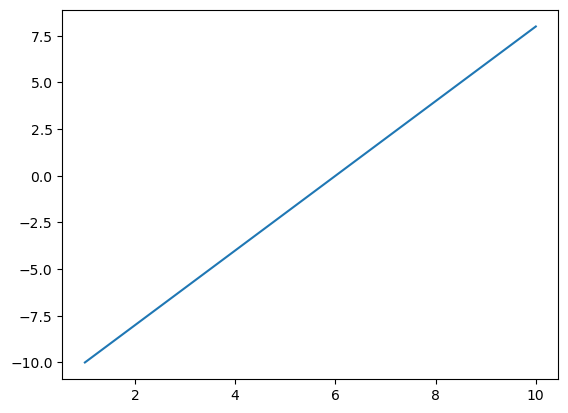

In [9]:
plt.plot(vols, grads)

In [10]:
for idx, vol in enumerate(vols):
    print(f"{vol}: {grads[idx]}")

1.0: -10.0
2.0: -8.0
3.0: -6.0
4.0: -4.0
5.0: -2.0
6.0: 0.0
7.0: 2.0
8.0: 4.0
9.0: 6.0
10.0: 8.0


In [11]:
print(grid)
perims = t.linspace(1, 100, 100)

grads = []
for perim in perims:
    perim.requires_grad_()
    cell1 = CellKind(
        type_id=1,
        target_perimeter=perim,
        lambda_perimeter=lambda_perim1,
        target_volume=target_vol1,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost1
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, perim)[0]
    grads.append(grad.detach().numpy())
print(grads)

tensor([[[0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])
[array(-50., dtype=float32), array(-48., dtype=float32), array(-46., dtype=float32), array(-44., dtype=float32), array(-42., dtype=float32), array(-40., dtype=float32), array(-38., dtype=float32), array(-36., dtype=float32), array(-34., dtype=float32), array(-32., dtype=float32), array(-30., dtype=float32), array(-28., dtype=float32), array(-26., dtype=float32), array(-24., dtype=float32), array(-22., dtype=float32), array(-20., dtype=float32), array(-18., dtype=float32), array(-16., dtype=float32), array(-14., dtype=float32), array(-12., dtype=float32), array(-10., dtype=float32), array(-8., dtype=float32), array(-6., dtype=float32), array(-4., dtype=float32), array(-2., dtype=float32), array(0., dtype=float32), array(2., dtype=float32), array(4., dtype=float32), array(6., dtype=float32), array(8., dtype=float32), array(10., dtype

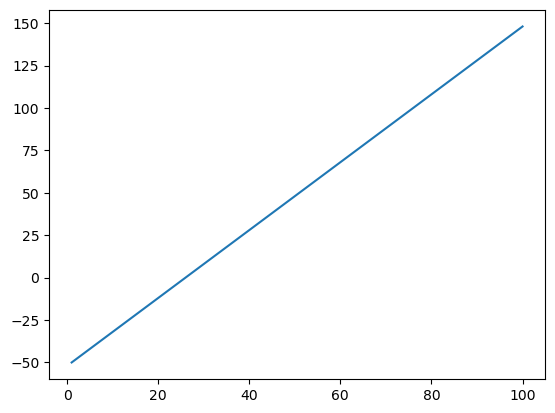

In [12]:
plt.plot(perims, grads)

In [13]:
print(grid)
adhesions = t.linspace(1, 100, 100)

e_vals = []
grads = []
for adh in adhesions:
    adh.requires_grad_()
    adh_cost = {
        0: adh
    }
    cell1 = CellKind(
        type_id=1,
        target_perimeter=target_perim1,
        lambda_perimeter=lambda_perim1,
        target_volume=target_vol1,
        lambda_volume=lambda_vol1,
        adhesion_cost=adh_cost
    )
    cell_map = CellMap()
    cell_map.add(cell_id=1, cell_type=cell1)
    e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
    grad = t.autograd.grad(e, adh)[0]
    grads.append(grad.detach().numpy())
    e_vals.append(e.detach().numpy())
print(grads)

tensor([[[0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])
[array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array(26., dtype=float32), array

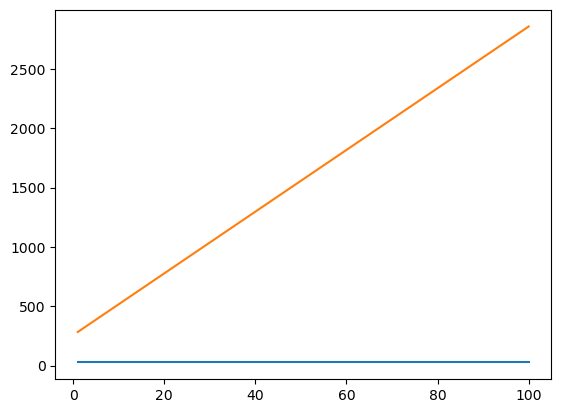

In [14]:
plt.plot(adhesions, grads)
plt.plot(adhesions, e_vals)

In [15]:
adh_cost1 = {0: t.tensor(2.)}
cell1 = CellKind(
    type_id=1,
    target_perimeter=target_perim1,
    lambda_perimeter=lambda_perim1,
    target_volume=target_vol1,
    lambda_volume=lambda_vol1,
    adhesion_cost=adh_cost1
)
cell_map = CellMap()
cell_map.add(cell_id=1, cell_type=cell1)
grid.requires_grad_()
e, stats = hamiltonian_energy(grid, cell_map, use_volume=True, use_perimeter=True, use_adhesion=True)
t.autograd.grad(e, grid)

(tensor([[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]),)

In [17]:
grid.requires_grad_()
loss = t.sum((grid - (grid.detach() + 1)) ** 2)
t.autograd.grad(loss, grid)

(tensor([[[-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.]]]),)

In [19]:
from volume_diff import volume_energy

volume_energy(grid, cell_map)



tensor([1.], grad_fn=<SumBackward1>)

In [49]:
from volume_diff import id_batched_volume

grid.requires_grad_()

loss_fn = t.nn.BCELoss()
loss = loss_fn(t.ones(grid.shape), grid)
test_loss = (loss - t.tensor(10.)) ** 2

grad = t.autograd.grad(test_loss, grid)

In [50]:
print(grad)

(tensor([[[-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf],
         [-inf, -inf, -inf, -inf, -inf]]]),)


In [23]:
a = t.tensor(2.)
a.requires_grad_()
loss = 0 ** ((a - t.tensor(4.)) ** 2)
t.autograd.grad(loss, a)

(tensor(-0.),)

In [24]:
loss

tensor(0., grad_fn=<PowBackward1>)

In [27]:
class STETest(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input == 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [30]:
loss = STETest.apply(a - t.tensor(4.))
t.autograd.grad(loss, a)

(tensor(1.),)

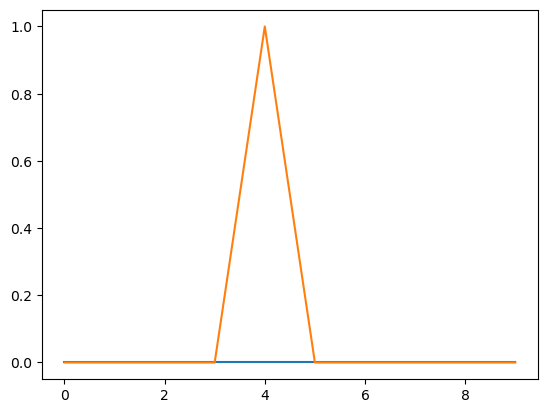

In [38]:
grads = []
losses = []
for i in range(10):
    a = t.tensor(float(i), requires_grad=True)
    loss = 0 ** ((a - t.tensor(4.)) ** 2)
    grad = t.autograd.grad(loss, a)[0]
    grads.append(grad.detach().numpy())
    losses.append(loss.detach().numpy())
plt.plot(range(10), grads)
plt.plot(range(10), losses)